In [ ]:
import os
print("Current directory:", os.getcwd())
print("Files in current directory:")
for item in os.listdir('.'):
    if os.path.isfile(item):
        print(f"  {item}")

Already up to date.
Content of dir:
total 216
drwxr-xr-x  3663 davide  staff  117216 21 Nov 12:15 dataset
-rw-r--r--@    1 davide  staff  110184 21 Nov 12:09 dataset.csv


In [ ]:
import pandas as pd
import os
from sklearn.model_selection import train_test_split

data = pd.read_csv('dataset.csv')
data['class_combined'] = data['type'] + '_' + data['state']

X = data[['name']]
y = data['class_combined']

X_temp, X_test, y_temp, y_test = train_test_split(
    X, y,
    test_size=0.15,
    random_state=42,
    stratify=y
)


X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp,
    test_size=0.176,
    random_state=42,
    stratify=y_temp
)

print("Train size:", len(X_train))
print("Validation size:", len(X_val))
print("Test size:", len(X_test))

Train size: 2564
Validation size: 548
Test size: 550


In [ ]:
import os
import numpy as np
from PIL import Image
import torchvision.transforms as T
import torch

train_transforms = T.Compose([
    T.Resize((128, 128)),
    T.RandomHorizontalFlip(p=0.5),
    T.RandomRotation(15),
    T.ColorJitter(brightness=0.2, contrast=0.2),
    T.ToTensor()
])

test_transforms = T.Compose([
    T.Resize((128, 128)),
    T.ToTensor()
])

def load_images_as_numpy(df, labels, root_dir, transform, n_aug=1):
    X_list = []
    y_list = []
    for i in range(len(df)):
        img_path = os.path.join(root_dir, df.iloc[i]["name"])
        img = Image.open(img_path).convert("RGB")
        for _ in range(n_aug):
            img_t = transform(img)
            img_np = img_t.numpy()
            X_list.append(img_np)
            y_list.append(labels.iloc[i])
    X = np.stack(X_list, axis=0)
    y = np.array(y_list)
    return X, y

root_dir = "datasetV1"

X_train_np, y_train_np = load_images_as_numpy(X_train, y_train, root_dir, train_transforms, n_aug=4)
X_val_np, y_val_np     = load_images_as_numpy(X_val,   y_val,   root_dir, test_transforms)
X_test_np, y_test_np   = load_images_as_numpy(X_test,  y_test,  root_dir, test_transforms)

print(X_train_np.shape, y_train_np.shape)
print(X_val_np.shape, y_val_np.shape)
print(X_test_np.shape, y_test_np.shape)

(10256, 3, 128, 128) (10256,)
(548, 3, 128, 128) (548,)
(550, 3, 128, 128) (550,)


## Only color hist (actual baseline)

In [5]:
import numpy as np
import cv2

def color_hist_features(X, bins=16, img_shape=(3, 128, 128)):
    n_samples = X.shape[0]
    feats = np.zeros((n_samples, 3 * bins), dtype=np.float32)
    bin_edges = np.linspace(0.0, 1.0, bins + 1)
    for i in range(n_samples):
        img = X[i].reshape(img_shape)
        img = np.transpose(img, (1, 2, 0))
        img = np.clip(img, 0.0, 1.0)
        img_hsv = cv2.cvtColor((img * 255.0).astype(np.uint8), cv2.COLOR_RGB2HSV)
        h, s, v = cv2.split(img_hsv)
        hists = []
        for channel in (h, s, v):
            ch_norm = channel.astype(np.float32) / 255.0
            hist, _ = np.histogram(ch_norm.ravel(), bins=bin_edges, density=True)
            hists.append(hist)
        feats[i] = np.concatenate(hists)
    return feats


In [6]:
X_train_color = color_hist_features(X_train_np, bins=16)
X_val_color   = color_hist_features(X_val_np,   bins=16)
X_test_color  = color_hist_features(X_test_np,  bins=16)

print(X_train_color.shape)
print(X_val_color.shape)
print(X_test_color.shape)


(10256, 48)
(548, 48)
(550, 48)


In [7]:
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

scaler_color = StandardScaler()
X_train_color_std = scaler_color.fit_transform(X_train_color)
X_val_color_std = scaler_color.transform(X_val_color)

k_list = [7, 9, 11, 13]
C_list = [20, 30, 40]
rf_depth_list = [30, 40]

print("kNN su feature colore")
best_knn_acc = 0.0
best_k = None
for k in k_list:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_color_std, y_train_np)
    y_val_pred = knn.predict(X_val_color_std)
    acc = accuracy_score(y_val_np, y_val_pred)
    print(f"kNN, k={k} -> val acc = {acc*100:.2f}%")
    if acc > best_knn_acc:
        best_knn_acc = acc
        best_k = k
print("Miglior kNN su validation:")
print(" k =", best_k)
print(" accuracy =", best_knn_acc*100, "%")
print()

print("SVM RBF su feature colore")
best_svm_acc = 0.0
best_C = None
for C in C_list:
    svm = SVC(kernel="rbf", C=C)
    svm.fit(X_train_color_std, y_train_np)
    y_val_pred = svm.predict(X_val_color_std)
    acc = accuracy_score(y_val_np, y_val_pred)
    print(f"SVM RBF, C={C} -> val acc = {acc*100:.2f}%")
    if acc > best_svm_acc:
        best_svm_acc = acc
        best_C = C
print("Miglior SVM su validation:")
print(" C =", best_C)
print(" accuracy =", best_svm_acc*100, "%")
print()

print("Random Forest su feature colore")
best_rf_acc = 0.0
best_rf_params = None
for depth in rf_depth_list:
    rf = RandomForestClassifier(
        n_estimators=300,
        max_depth=depth,
        max_features="sqrt",
        random_state=42,
        n_jobs=-1
    )
    rf.fit(X_train_color_std, y_train_np)
    y_val_pred = rf.predict(X_val_color_std)
    acc = accuracy_score(y_val_np, y_val_pred)
    print(f"RF, n_estimators=300], max_depth={depth}, max_features=sqrt -> val acc = {acc*100:.2f}%")
    if acc > best_rf_acc:
        best_rf_acc = acc
        best_rf_params = {"n_estimators": 300, "max_depth": depth, "max_features": "sqrt"}
print("Miglior RF su validation:")
print(" params =", best_rf_params)
print(" accuracy =", best_rf_acc*100, "%")


kNN su feature colore
kNN, k=7 -> val acc = 48.54%
kNN, k=9 -> val acc = 50.55%
kNN, k=11 -> val acc = 49.45%
kNN, k=13 -> val acc = 50.55%
Miglior kNN su validation:
 k = 9
 accuracy = 50.54744525547446 %

SVM RBF su feature colore
SVM RBF, C=20 -> val acc = 56.75%
SVM RBF, C=30 -> val acc = 57.66%
SVM RBF, C=40 -> val acc = 57.12%
Miglior SVM su validation:
 C = 30
 accuracy = 57.66423357664233 %

Random Forest su feature colore
RF, n_estimators=300], max_depth=30, max_features=sqrt -> val acc = 63.50%
RF, n_estimators=300], max_depth=40, max_features=sqrt -> val acc = 63.50%
Miglior RF su validation:
 params = {'n_estimators': 300, 'max_depth': 30, 'max_features': 'sqrt'}
 accuracy = 63.503649635036496 %


Validation accuracy RF (color, 300 trees, depth 30): 63.50%
Classification report RF (color):
                     precision    recall  f1-score   support

      apple_healthy      0.667     0.688     0.677        32
       apple_rotten      0.700     0.233     0.350        30
     banana_healthy      0.649     0.750     0.696        32
      banana_rotten      0.706     0.774     0.738        31
   cucumber_healthy      0.839     0.839     0.839        31
    cucumber_rotten      0.600     0.700     0.646        30
      grape_healthy      0.488     0.700     0.575        30
       grape_rotten      0.562     0.600     0.581        30
      mango_healthy      0.538     0.467     0.500        30
       mango_rotten      0.607     0.567     0.586        30
     orange_healthy      0.800     0.667     0.727        30
      orange_rotten      0.739     0.567     0.642        30
pomegranate_healthy      0.714     0.806     0.758        31
 pomegranate_rotten      0.565     0.433     0.491 

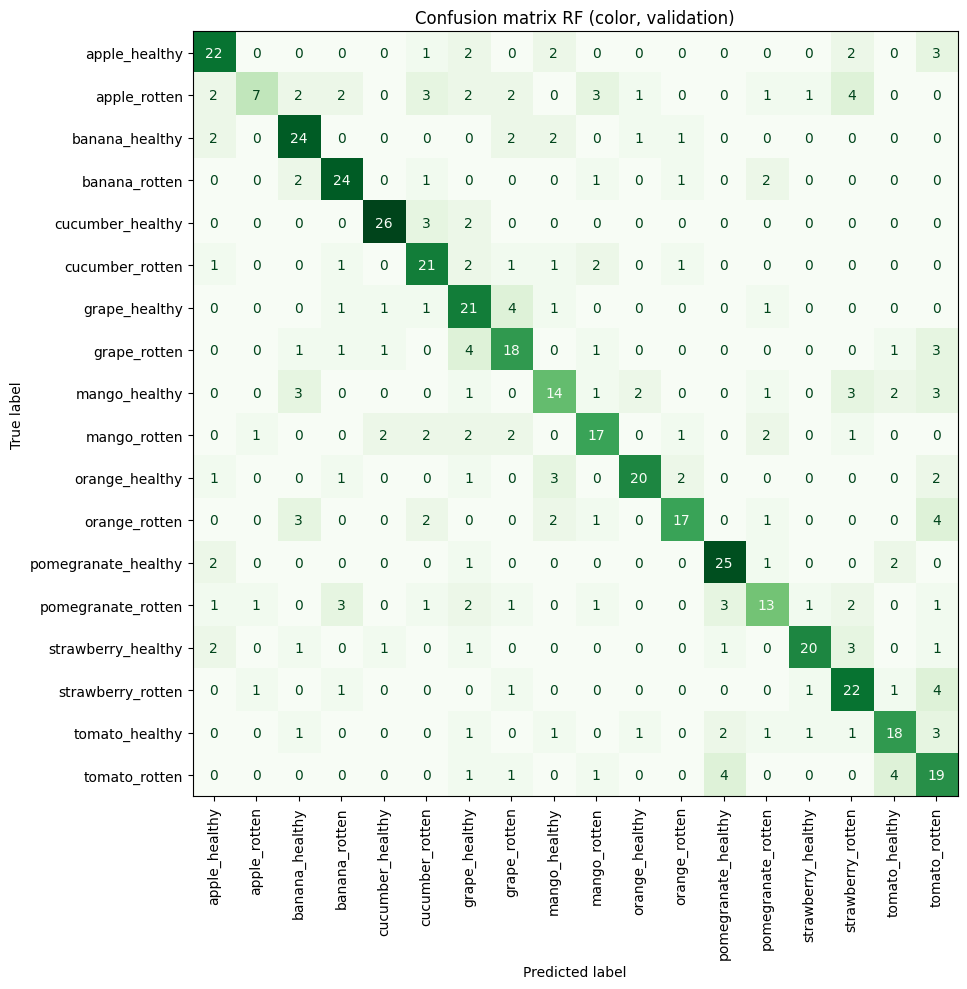

In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

rf_color_best = RandomForestClassifier(
    n_estimators=300,
    max_depth=30,
    max_features="sqrt",
    random_state=42,
    n_jobs=-1
)
rf_color_best.fit(X_train_color_std, y_train_np)

y_val_pred_rf = rf_color_best.predict(X_val_color_std)
val_acc_rf = accuracy_score(y_val_np, y_val_pred_rf)
print(f"Validation accuracy RF (color, 300 trees, depth 30): {val_acc_rf*100:.2f}%")

print("Classification report RF (color):")
print(classification_report(y_val_np, y_val_pred_rf, digits=3))

labels = np.unique(y_train_np)
cm_rf = confusion_matrix(y_val_np, y_val_pred_rf, labels=labels)

fig, ax = plt.subplots(figsize=(10, 10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=labels)
disp.plot(ax=ax, xticks_rotation=90, cmap="Greens", colorbar=False)
plt.title("Confusion matrix RF (color, validation)")
plt.tight_layout()
plt.show()


## Hog + color hist bad af cause hog too much feature

In [9]:
# X_train_hog = extract_hog_features(X_train_np)
# X_val_hog = extract_hog_features(X_val_np)
# X_test_hog = extract_hog_features(X_test_np)

# print(X_train_hog.shape)
# print(X_val_hog.shape)
# print(X_test_hog.shape)

In [10]:
# X_train_full = np.concatenate([X_train_color, X_train_hog], axis=1)
# X_val_full = np.concatenate([X_val_color, X_val_hog], axis=1)
# X_test_full = np.concatenate([X_test_color, X_test_hog], axis=1)

# print(X_train_full.shape, X_val_full.shape, X_test_full.shape)


In [11]:
#bad so full commented

# from sklearn.preprocessing import StandardScaler
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.svm import SVC
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.metrics import accuracy_score

# scaler_full = StandardScaler()
# X_train_full_std = scaler_full.fit_transform(X_train_full)
# X_val_full_std = scaler_full.transform(X_val_full)

# k_list = [5, 9, 13]
# C_list = [10, 20, 40]
# rf_depth_list = [20, 30]

# print("kNN su feature color+HOG")
# best_knn_acc = 0.0
# best_k = None
# for k in k_list:
#     knn = KNeighborsClassifier(n_neighbors=k)
#     knn.fit(X_train_full_std, y_train_np)
#     y_val_pred = knn.predict(X_val_full_std)
#     acc = accuracy_score(y_val_np, y_val_pred)
#     print(f"kNN, k={k} -> val acc = {acc*100:.2f}%")
#     if acc > best_knn_acc:
#         best_knn_acc = acc
#         best_k = k
# print("Miglior kNN color+HOG:", best_k, best_knn_acc*100, "%")
# print()

# print("SVM RBF su feature color+HOG")
# best_svm_acc = 0.0
# best_C = None
# for C in C_list:
#     svm = SVC(kernel="rbf", C=C, gamma="scale")
#     svm.fit(X_train_full_std, y_train_np)
#     y_val_pred = svm.predict(X_val_full_std)
#     acc = accuracy_score(y_val_np, y_val_pred)
#     print(f"SVM RBF, C={C} -> val acc = {acc*100:.2f}%")
#     if acc > best_svm_acc:
#         best_svm_acc = acc
#         best_C = C
# print("Miglior SVM color+HOG:", best_C, best_svm_acc*100, "%")
# print()

# print("Random Forest su feature color+HOG")
# best_rf_acc = 0.0
# best_rf_params = None
# for depth in rf_depth_list:
#     rf = RandomForestClassifier(
#         n_estimators=300,
#         max_depth=depth,
#         max_features="sqrt",
#         random_state=42,
#         n_jobs=-1
#     )
#     rf.fit(X_train_full_std, y_train_np)
#     y_val_pred = rf.predict(X_val_full_std)
#     acc = accuracy_score(y_val_np, y_val_pred)
#     print(f"RF, 300 trees, max_depth={depth} -> val acc = {acc*100:.2f}%")
#     if acc > best_rf_acc:
#         best_rf_acc = acc
#         best_rf_params = {"n_estimators": 300, "max_depth": depth, "max_features": "sqrt"}
# print("Miglior RF color+HOG:", best_rf_params, best_rf_acc*100, "%")

## color hist + hsv (not bad but only color hist better with less features)

In [12]:
# import cv2
# import numpy as np

# def color_ext_features_from_array(img_np, bins=16):
#     img = img_np.reshape(3, 128, 128)
#     img = np.transpose(img, (1, 2, 0))
#     img = np.clip(img, 0.0, 1.0)
#     img_hsv = cv2.cvtColor((img * 255.0).astype(np.uint8), cv2.COLOR_RGB2HSV)
#     h, s, v = cv2.split(img_hsv)
#     h = h.astype(np.float32) / 255.0
#     s = s.astype(np.float32) / 255.0
#     v = v.astype(np.float32) / 255.0
#     bin_edges = np.linspace(0.0, 1.0, bins + 1)
#     hists = []
#     for ch in (h, s, v):
#         hist, _ = np.histogram(ch.ravel(), bins=bin_edges, density=True)
#         hists.append(hist)
#     moments = []
#     for ch in (h, s, v):
#         x = ch.ravel()
#         mean = x.mean()
#         std = x.std() + 1e-8
#         skew = np.mean(((x - mean) / std) ** 3)
#         moments.extend([mean, std, skew])
#     feat = np.concatenate(hists + [np.array(moments, dtype=np.float32)])
#     return feat

# def extract_color_ext_features(X_np, bins=16):
#     feats = [color_ext_features_from_array(X_np[i], bins) for i in range(X_np.shape[0])]
#     return np.stack(feats, axis=0)


In [13]:
# X_train_color_ext = extract_color_ext_features(X_train_np, bins=16)
# X_val_color_ext = extract_color_ext_features(X_val_np, bins=16)
# X_test_color_ext = extract_color_ext_features(X_test_np, bins=16)

# print(X_train_color_ext.shape)
# print(X_val_color_ext.shape)
# print(X_test_color_ext.shape)


In [14]:
# from sklearn.preprocessing import StandardScaler
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.svm import SVC
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.metrics import accuracy_score

# scaler_color_ext = StandardScaler()
# X_train_color_ext_std = scaler_color_ext.fit_transform(X_train_color_ext)
# X_val_color_ext_std = scaler_color_ext.transform(X_val_color_ext)

# k_list = [1,3,5,7,9,11]
# C_list = [0.1, 1, 10, 20]
# rf_depth_list = [20, 30]

# print("kNN su feature colore esteso")
# best_knn_acc = 0.0
# best_k = None
# for k in k_list:
#     knn = KNeighborsClassifier(n_neighbors=k)
#     knn.fit(X_train_color_ext_std, y_train_np)
#     y_val_pred = knn.predict(X_val_color_ext_std)
#     acc = accuracy_score(y_val_np, y_val_pred)
#     print(f"kNN, k={k} -> val acc = {acc*100:.2f}%")
#     if acc > best_knn_acc:
#         best_knn_acc = acc
#         best_k = k
# print("Miglior kNN colore esteso:", best_k, best_knn_acc*100, "%")
# print()

# print("SVM RBF su feature colore esteso")
# best_svm_acc = 0.0
# best_C = None
# for C in C_list:
#     svm = SVC(kernel="rbf", C=C, gamma="scale")
#     svm.fit(X_train_color_ext_std, y_train_np)
#     y_val_pred = svm.predict(X_val_color_ext_std)
#     acc = accuracy_score(y_val_np, y_val_pred)
#     print(f"SVM RBF, C={C} -> val acc = {acc*100:.2f}%")
#     if acc > best_svm_acc:
#         best_svm_acc = acc
#         best_C = C
# print("Miglior SVM colore esteso:", best_C, best_svm_acc*100, "%")
# print()

# print("Random Forest su feature colore esteso")
# best_rf_acc = 0.0
# best_rf_params = None
# for depth in rf_depth_list:
#     rf = RandomForestClassifier(
#         n_estimators=400,
#         max_depth=depth,
#         max_features="sqrt",
#         random_state=42,
#         n_jobs=-1
#     )
#     rf.fit(X_train_color_ext_std, y_train_np)
#     y_val_pred = rf.predict(X_val_color_ext_std)
#     acc = accuracy_score(y_val_np, y_val_pred)
#     print(f"RF, 400 trees, max_depth={depth} -> val acc = {acc*100:.2f}%")
#     if acc > best_rf_acc:
#         best_rf_acc = acc
#         best_rf_params = {"n_estimators": 400, "max_depth": depth, "max_features": "sqrt"}
# print("Miglior RF colore esteso:", best_rf_params, best_rf_acc*100, "%")


## Color hist + GLCM

In [15]:
from skimage.color import rgb2gray
from skimage.feature import graycomatrix, graycoprops

def glcm_features_from_array(img_np):
    img = img_np.reshape(3, 128, 128)
    img = np.transpose(img, (1, 2, 0))
    img = np.clip(img, 0.0, 1.0)
    gray = rgb2gray(img)
    gray = (gray * 255).astype(np.uint8)
    distances = [1]
    angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]
    glcm = graycomatrix(gray, distances=distances, angles=angles,
                        levels=256, symmetric=True, normed=True)
    feats = []
    for prop in ["contrast", "homogeneity", "energy", "correlation"]:
        vals = graycoprops(glcm, prop)[0]
        feats.append(vals.mean())
    return np.array(feats, dtype=np.float32)

def extract_glcm_features(X_np):
    feats = [glcm_features_from_array(X_np[i]) for i in range(X_np.shape[0])]
    return np.stack(feats, axis=0)


In [16]:
X_train_glcm = extract_glcm_features(X_train_np)
X_val_glcm = extract_glcm_features(X_val_np)
X_test_glcm = extract_glcm_features(X_test_np)

print(X_train_glcm.shape)
print(X_val_glcm.shape)
print(X_test_glcm.shape)


(10256, 4)
(548, 4)
(550, 4)


In [17]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

X_train_ct = np.concatenate([X_train_color, X_train_glcm], axis=1)
X_val_ct = np.concatenate([X_val_color, X_val_glcm], axis=1)
X_test_ct = np.concatenate([X_test_color, X_test_glcm], axis=1)

print(X_train_ct.shape, X_val_ct.shape, X_test_ct.shape)


(10256, 52) (548, 52) (550, 52)


In [18]:
scaler_ct = StandardScaler()
X_train_ct_std = scaler_ct.fit_transform(X_train_ct)
X_val_ct_std = scaler_ct.transform(X_val_ct)

k_list = [1, 3, 5, 7, 9, 11, 13]
C_list = [10, 20, 40]
rf_depth_list = [20, 30, 40]

print("kNN su feature colore+GLCM")
best_knn_acc = 0.0
best_k = None
for k in k_list:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_ct_std, y_train_np)
    y_val_pred = knn.predict(X_val_ct_std)
    acc = accuracy_score(y_val_np, y_val_pred)
    print(f"kNN, k={k} -> val acc = {acc*100:.2f}%")
    if acc > best_knn_acc:
        best_knn_acc = acc
        best_k = k
print("Miglior kNN colore+GLCM:", best_k, best_knn_acc*100, "%")
print()

print("SVM RBF su feature colore+GLCM")
best_svm_acc = 0.0
best_C = None
for C in C_list:
    svm = SVC(kernel="rbf", C=C, gamma="scale")
    svm.fit(X_train_ct_std, y_train_np)
    y_val_pred = svm.predict(X_val_ct_std)
    acc = accuracy_score(y_val_np, y_val_pred)
    print(f"SVM RBF, C={C} -> val acc = {acc*100:.2f}%")
    if acc > best_svm_acc:
        best_svm_acc = acc
        best_C = C
print("Miglior SVM colore+GLCM:", best_C, best_svm_acc*100, "%")
print()

print("Random Forest su feature colore+GLCM")
best_rf_acc = 0.0
best_rf_params = None
for depth in rf_depth_list:
    rf = RandomForestClassifier(
        n_estimators=300,
        max_depth=depth,
        max_features="sqrt",
        random_state=42,
        n_jobs=-1
    )
    rf.fit(X_train_ct_std, y_train_np)
    y_val_pred = rf.predict(X_val_ct_std)
    acc = accuracy_score(y_val_np, y_val_pred)
    print(f"RF, 300 trees, max_depth={depth} -> val acc = {acc*100:.2f}%")
    if acc > best_rf_acc:
        best_rf_acc = acc
        best_rf_params = {"n_estimators": 300, "max_depth": depth, "max_features": "sqrt"}
print("Miglior RF colore+GLCM:", best_rf_params, best_rf_acc*100, "%")


kNN su feature colore+GLCM
kNN, k=1 -> val acc = 45.99%
kNN, k=3 -> val acc = 44.53%
kNN, k=5 -> val acc = 46.72%
kNN, k=7 -> val acc = 47.08%
kNN, k=9 -> val acc = 47.08%
kNN, k=11 -> val acc = 46.35%
kNN, k=13 -> val acc = 46.17%
Miglior kNN colore+GLCM: 7 47.08029197080292 %

SVM RBF su feature colore+GLCM
SVM RBF, C=10 -> val acc = 57.12%
SVM RBF, C=20 -> val acc = 58.03%
SVM RBF, C=40 -> val acc = 56.93%
Miglior SVM colore+GLCM: 20 58.02919708029197 %

Random Forest su feature colore+GLCM
RF, 300 trees, max_depth=20 -> val acc = 63.14%
RF, 300 trees, max_depth=30 -> val acc = 64.23%
RF, 300 trees, max_depth=40 -> val acc = 64.23%
Miglior RF colore+GLCM: {'n_estimators': 300, 'max_depth': 30, 'max_features': 'sqrt'} 64.23357664233576 %


## Color + lbp

In [19]:
from skimage.color import rgb2gray
from skimage.feature import local_binary_pattern

def lbp_features_from_array(img_np, P=8, R=1, n_bins=16):
    img = img_np.reshape(3, 128, 128)
    img = np.transpose(img, (1, 2, 0))
    img = np.clip(img, 0.0, 1.0)
    gray = rgb2gray(img)
    lbp = local_binary_pattern(gray, P=P, R=R, method="uniform")
    lbp = lbp.astype(np.float32)
    lbp_norm = lbp / lbp.max()
    hist, _ = np.histogram(lbp_norm.ravel(), bins=n_bins, range=(0.0, 1.0), density=True)
    return hist.astype(np.float32)

def extract_lbp_features(X_np, P=8, R=1, n_bins=16):
    feats = [lbp_features_from_array(X_np[i], P=P, R=R, n_bins=n_bins) for i in range(X_np.shape[0])]
    return np.stack(feats, axis=0)


In [20]:
X_train_lbp = extract_lbp_features(X_train_np)
X_val_lbp = extract_lbp_features(X_val_np)
X_test_lbp = extract_lbp_features(X_test_np)

print(X_train_lbp.shape)
print(X_val_lbp.shape)
print(X_test_lbp.shape)


/usr/local/lib/python3.12/dist-packages/skimage/feature/texture.py:385: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


(10256, 16)
(548, 16)
(550, 16)


In [21]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

X_train_cl = np.concatenate([X_train_color, X_train_lbp], axis=1)
X_val_cl = np.concatenate([X_val_color, X_val_lbp], axis=1)
X_test_cl = np.concatenate([X_test_color, X_test_lbp], axis=1)

print(X_train_cl.shape, X_val_cl.shape, X_test_cl.shape)


(10256, 64) (548, 64) (550, 64)


In [22]:
scaler_cl = StandardScaler()
X_train_cl_std = scaler_cl.fit_transform(X_train_cl)
X_val_cl_std = scaler_cl.transform(X_val_cl)
X_test_cl_std = scaler_cl.transform(X_test_cl)

k_list = [1, 3, 5, 7, 9, 11, 13]
C_list = [10, 20, 40]
rf_depth_list = [20, 30, 40]

print("kNN su feature colore+LBP")
best_knn_acc = 0.0
best_k = None
for k in k_list:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_cl_std, y_train_np)
    y_val_pred = knn.predict(X_val_cl_std)
    acc = accuracy_score(y_val_np, y_val_pred)
    print(f"kNN, k={k} -> val acc = {acc*100:.2f}%")
    if acc > best_knn_acc:
        best_knn_acc = acc
        best_k = k
print("Miglior kNN colore+LBP:", best_k, best_knn_acc*100, "%")
print()

print("SVM RBF su feature colore+LBP")
best_svm_acc = 0.0
best_C = None
for C in C_list:
    svm = SVC(kernel="rbf", C=C, gamma="scale")
    svm.fit(X_train_cl_std, y_train_np)
    y_val_pred = svm.predict(X_val_cl_std)
    acc = accuracy_score(y_val_np, y_val_pred)
    print(f"SVM RBF, C={C} -> val acc = {acc*100:.2f}%")
    if acc > best_svm_acc:
        best_svm_acc = acc
        best_C = C
print("Miglior SVM colore+LBP:", best_C, best_svm_acc*100, "%")
print()

print("Random Forest su feature colore+LBP")
best_rf_acc = 0.0
best_rf_params = None
for depth in rf_depth_list:
    rf = RandomForestClassifier(
        n_estimators=400,
        max_depth=depth,
        max_features="sqrt",
        random_state=42,
        n_jobs=-1
    )
    rf.fit(X_train_cl_std, y_train_np)
    y_val_pred = rf.predict(X_val_cl_std)
    acc = accuracy_score(y_val_np, y_val_pred)
    print(f"RF, 400 trees, max_depth={depth} -> val acc = {acc*100:.2f}%")
    if acc > best_rf_acc:
        best_rf_acc = acc
        best_rf_params = {"n_estimators": 400, "max_depth": depth, "max_features": "sqrt"}
print("Miglior RF colore+LBP:", best_rf_params, best_rf_acc*100, "%")


kNN su feature colore+LBP
kNN, k=1 -> val acc = 54.20%
kNN, k=3 -> val acc = 51.82%
kNN, k=5 -> val acc = 52.01%
kNN, k=7 -> val acc = 52.74%
kNN, k=9 -> val acc = 52.92%
kNN, k=11 -> val acc = 52.55%
kNN, k=13 -> val acc = 53.65%
Miglior kNN colore+LBP: 1 54.1970802919708 %

SVM RBF su feature colore+LBP
SVM RBF, C=10 -> val acc = 64.05%
SVM RBF, C=20 -> val acc = 64.42%
SVM RBF, C=40 -> val acc = 64.42%
Miglior SVM colore+LBP: 20 64.41605839416059 %

Random Forest su feature colore+LBP
RF, 400 trees, max_depth=20 -> val acc = 64.78%
RF, 400 trees, max_depth=30 -> val acc = 65.15%
RF, 400 trees, max_depth=40 -> val acc = 65.33%
Miglior RF colore+LBP: {'n_estimators': 400, 'max_depth': 40, 'max_features': 'sqrt'} 65.32846715328468 %


## SFS (RF) on Color + LBP

In [23]:
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.ensemble import RandomForestClassifier

rf_base = RandomForestClassifier(
    n_estimators=10,
    random_state=42,
    n_jobs=-1
)

sfs_rf = SequentialFeatureSelector(
    rf_base,
    n_features_to_select=5,
    direction="forward",
    scoring="accuracy",
    n_jobs=-1
)

sfs_rf.fit(X_train_cl_std, y_train_np)
mask_rf = sfs_rf.get_support()
idx_rf = np.where(mask_rf)[0]
print("RF-SFS, num feature selezionate:", len(idx_rf))
print("Indici RF-SFS:", idx_rf)


RF-SFS, num feature selezionate: 5
Indici RF-SFS: [ 0  1  2 16 48]


In [24]:
X_train_rf_sfs = X_train_cl_std[:, mask_rf]
X_val_rf_sfs = X_val_cl_std[:, mask_rf]
X_test_rf_sfs = X_test_cl_std[:, mask_rf]

print(X_train_rf_sfs.shape, X_val_rf_sfs.shape, X_test_rf_sfs.shape)


(10256, 5) (548, 5) (550, 5)


In [25]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

rf_strong = RandomForestClassifier(
    n_estimators=400,
    max_depth=30,
    max_features="sqrt",
    random_state=42,
    n_jobs=-1
)
rf_strong.fit(X_train_rf_sfs, y_train_np)
y_val_pred_rf = rf_strong.predict(X_val_rf_sfs)
print("Val acc RF forte su RF-SFS:", accuracy_score(y_val_np, y_val_pred_rf)*100, "%")

svm_rbf = SVC(kernel="rbf", C=20)
svm_rbf.fit(X_train_rf_sfs, y_train_np)
y_val_pred_svm = svm_rbf.predict(X_val_rf_sfs)
print("Val acc SVM RBF su RF-SFS:", accuracy_score(y_val_np, y_val_pred_svm)*100, "%")


Val acc RF forte su RF-SFS: 44.16058394160584 %
Val acc SVM RBF su RF-SFS: 41.058394160583944 %


## SFS (SVC) on Color + LBP

In [26]:
from sklearn.svm import LinearSVC

svm_base = LinearSVC(C=1.0, max_iter=5000)

sfs_svm = SequentialFeatureSelector(
    svm_base,
    n_features_to_select=20,
    direction="forward",
    scoring="accuracy",
    cv=3,
    n_jobs=-1
)

sfs_svm.fit(X_train_cl_std, y_train_np)
mask_svm = sfs_svm.get_support()
idx_svm = np.where(mask_svm)[0]
print("SVM-SFS, num feature selezionate:", len(idx_svm))
print("Indici SVM-SFS:", idx_svm)


SVM-SFS, num feature selezionate: 20
Indici SVM-SFS: [ 0  1  2  3  4  5 11 16 17 19 22 29 34 37 42 51 53 55 56 58]


In [27]:
X_train_svm_sfs = X_train_cl_std[:, mask_svm]
X_val_svm_sfs = X_val_cl_std[:, mask_svm]
X_test_svm_sfs = X_test_cl_std[:, mask_svm]

print(X_train_svm_sfs.shape, X_val_svm_sfs.shape, X_test_svm_sfs.shape)


(10256, 20) (548, 20) (550, 20)


In [28]:
rf_strong_svm = RandomForestClassifier(
    n_estimators=400,
    max_depth=30,
    random_state=42,
    n_jobs=-1
)
rf_strong_svm.fit(X_train_svm_sfs, y_train_np)
y_val_pred_rf2 = rf_strong_svm.predict(X_val_svm_sfs)
print("Val acc RF forte su SVM-SFS:", accuracy_score(y_val_np, y_val_pred_rf2)*100, "%")

svm_rbf2 = SVC(kernel="rbf", C=20, gamma="scale")
svm_rbf2.fit(X_train_svm_sfs, y_train_np)
y_val_pred_svm2 = svm_rbf2.predict(X_val_svm_sfs)
print("Val acc SVM RBF su SVM-SFS:", accuracy_score(y_val_np, y_val_pred_svm2)*100, "%")


Val acc RF forte su SVM-SFS: 62.59124087591241 %
Val acc SVM RBF su SVM-SFS: 59.306569343065696 %
